In [1]:
import torch
from resnet import validate, ResNet, get_data_loader
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, precision_recall_fscore_support
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
day_data_path = '/data/work_amimukh/Journal_IEEE/BDD_Images/TestDay'
night_data_path = '/data/work_amimukh/Journal_IEEE/BDD_Images/TestNight'

In [3]:
res_model = ResNet()

In [21]:
res_model.load_model('/data/work_amimukh/Journal_IEEE/mobilenet_model_day_syn_night/run_000/resmodel.pth') #DAY
#res_model.load_model('/data/work_amimukh/Journal_IEEE/resnet_50_model_day_night/run_000/resmodel.pth') #DAYNIGHT
#res_model.load_model('/data/work_amimukh/Journal_IEEE/resnet_50_model_day_syn_night/run_000/resmodel.pth') #DAYSYNTHNIGHT

In [22]:
dl_day = get_data_loader(day_data_path, mode='test', batch_size=64)
dl_night = get_data_loader(night_data_path, mode='test', batch_size=64)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
day_res = []
labels = []
res_model = res_model.to(device)
for img, label in dl_day:
    img = img.to(device)
    label = label.to(device)
    preds = res_model(img)
    day_res.append(preds.cpu().detach().numpy())
    labels.append(label.cpu().detach().numpy())
labels_ = np.hstack(labels)
day_res_ = np.vstack(day_res)
cl_map = dl_day.dataset.class_to_idx
pr_day = {i:[] for i in cl_map.keys()}
re_day = {i:[] for i in cl_map.keys()}
plt.figure(figsize=(10, 10))
for label in cl_map.keys():
    label_idx = cl_map[label]
    pr_day[label], re_day[label], _ = precision_recall_curve(labels_, day_res_[:,label_idx], pos_label = label_idx)
    #plt.plot(re[label], pr[label], lw=2, label='{}'.format(label))#age_precision_score(labels_, day_res_[:,label_idx], average='micro', pos_label=label_idx)))
    #rec, rec, f = precision_recall_fscore_support(labels_, day_res_[:,label_idx], pos_label=label_idx)
    #rint(label)
   #print('cision:{}, recall:{}, f:{}'.format(prec, rec, f))
#plt.legend()
prec, rec, f, _ = precision_recall_fscore_support(labels_, np.argmax(day_res_, axis=1), average=None)
for idx, l in enumerate(cl_map.keys()):
    print('{}, {}, {}, {}'.format(l, prec[idx], rec[idx], f[idx]))

cars, 0.8595209094600081, 0.8176902278872151, 0.8380839271575614
person, 0.5349555813055233, 0.8404126213592233, 0.6537644559830068
trafficlight, 0.3804573804573805, 0.5954446854663774, 0.4642706131078224
trafficsign, 0.770637268082818, 0.6127859739149027, 0.6827060505002382


<Figure size 720x720 with 0 Axes>

In [25]:
cl_map = dl_night.dataset.class_to_idx
night_res = []
labels = []
res_model = res_model.to(device)
for img, label in dl_night:
    img = img.to(device)
    label = label.to(device)
    preds = res_model(img)
    night_res.append(preds.cpu().detach().numpy())
    labels.append(label.cpu().detach().numpy())
labels_ = np.hstack(labels)
night_res_ = np.vstack(night_res)
pr_night = {i:[] for i in cl_map.keys()}
re_night = {i:[] for i in cl_map.keys()}
plt.figure(figsize=(10, 10))
for label in cl_map.keys():
    label_idx = cl_map[label]
    pr_night[label], re_night[label], _ = precision_recall_curve(labels_, night_res_[:,label_idx], pos_label = label_idx)
    #plt.plot(re[label], pr[label], lw=2, label='{}'.format(label))#age_precision_score(labels_, day_res_[:,label_idx], average='micro', pos_label=label_idx)))
    #rec, rec, f = precision_recall_fscore_support(labels_, day_res_[:,label_idx], pos_label=label_idx)
    #rint(label)
   #print('cision:{}, recall:{}, f:{}'.format(prec, rec, f))
#plt.legend()
prec, rec, f, _ = precision_recall_fscore_support(labels_, np.argmax(night_res_, axis=1), average=None)
for idx, l in enumerate(cl_map.keys()):
    print('{}, {}, {}, {}'.format(l, prec[idx], rec[idx], f[idx]))

cars, 0.8405819063494469, 0.7401921537229784, 0.7871993188107571
person, 0.35235378031383735, 0.7682737169517885, 0.48312958435207826
trafficlight, 0.3054662379421222, 0.46454767726161367, 0.3685741998060136
trafficsign, 0.674492385786802, 0.6176641487507263, 0.6448286320897786


<Figure size 720x720 with 0 Axes>

In [26]:
res_model = res_model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
validate(res_model, device, dl_day, loss_fn)

(327.5181292475463, 0.8831449184798046)

In [27]:
validate(res_model, device, dl_night, loss_fn)

(244.73414935923938, 0.8715818343147536)

In [28]:
def validate_non_equal(model, device, ds_loader, criterion, reqlabel):
    model.eval()
    corrects = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in ds_loader:
            inputs, label = inputs.to(device), labels.to(device)
            output = model(inputs)
            pred = output.max(1, keepdim=True)[1]
            if pred != label and reqlabel == label:
                return inputs
                
            #val_loss += criterion(output, label).item()
            #preds = output.max(1, keepdim=True)[1]
            #corrects += preds.eq(label.view_as(preds)).sum().item()
        acc = corrects / float(len(ds_loader.dataset))
    return val_loss, acc

In [21]:
ig = validate_non_equal(res_model, device, dl_night, loss_fn, 0)

In [23]:
ig2 = ig.cpu().detach().numpy().transpose(2,3,1,0)[...,0]

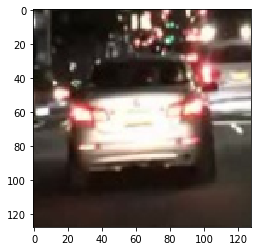

In [28]:
plt.imshow((ig2 -ig2.min()) / ig2.ptp())